# Stock Price Prediction and Investment Recommendations
---
## Summary

**Background:**

We are a portfolio investment company and we make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.

Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.

**Data Description:**

You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data.

**Goal(s):**

Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.

**Success Metrics:**

Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectiveness.

# Import Libraries

In [51]:
# Standards
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statistics
import random

# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# Prophet
from prophet import Prophet

import logging

# Set logging level to ERROR to suppress Prophet's output
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
#logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Warnings
import warnings

# Suppress deprecation warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


# Data Preprocessing

## Data Loading

- Load data from different sheets for each company.
- Combine data into a single dataframe with an additional column indicating the company.

In [52]:
# Load data from Excel file
file_name = r"data\2020Q1Q2Q3Q4-2021Q1.xlsx"
xlsx = pd.ExcelFile(file_name)

# Get company names from sheet names
company_names = xlsx.sheet_names

# Load data from each sheet and store in a list of dataframes
dfs = []
for company in company_names:
    df = pd.read_excel(xlsx, company, skipfooter=1)
    df['Company'] = company  # Add a column to identify the company
    dfs.append(df)

# Combine all dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)

## Data Splitting

- Split data into training (2020) and testing (2021 Q1) sets.

In [53]:
# Split the data into training and test sets
train = combined_df[combined_df['Date'].dt.year == 2020]
test = combined_df[combined_df['Date'].dt.year == 2021]

## Data Cleaning

- Handle missing values.
- Convert date columns to datetime format.
- Ensure data consistency (e.g., stock prices should be non-negative).

In [54]:
# Handle missing values (fill or drop)
# First, check the number of missing values for each column
missing_values = combined_df.isnull().sum()
print(missing_values)

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
Company     0
dtype: int64


In [55]:
# Convert 'Date' column to datetime format
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Data consistency
# Replace any negative stock prices with NaN (not a number)
combined_df.loc[combined_df['Price'] < 0, 'Price'] = None
combined_df.loc[combined_df['Open'] < 0, 'Open'] = None
combined_df.loc[combined_df['High'] < 0, 'High'] = None
combined_df.loc[combined_df['Low'] < 0, 'Low'] = None

# Convert 'Vol.' column to a consistent format
def volume_conversion(vol):
    if 'M' in vol:
        return float(vol.replace('M', '')) * 1_000_000
    elif 'K' in vol:
        return float(vol.replace('K', '')) * 1_000
    elif vol == '-':
        return None  # Convert '-' to NaN
    else:
        return float(vol)

combined_df['Vol.'] = combined_df['Vol.'].astype(str).apply(volume_conversion)

# Convert 'Change %' to a float 
# (remove the '%' sign and divide by 100)
combined_df['Change %'] = combined_df['Change %'].astype(str).str.rstrip('%').astype('float') / 100.0


## Data Scaling

In [56]:
# Data Preprocessing Function
def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    X, y = [], []
    for i in range(60, len(scaled_data)):  # Using a window of 60 days
        X.append(scaled_data[i-60:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

## Feature Engineering

- Calculate technical indicators like Moving Averages, RSI, MACD, etc.
- Calculate historical returns for various periods (daily, weekly, monthly).
- Create lag features to capture temporal dependencies.

### Moving Averages

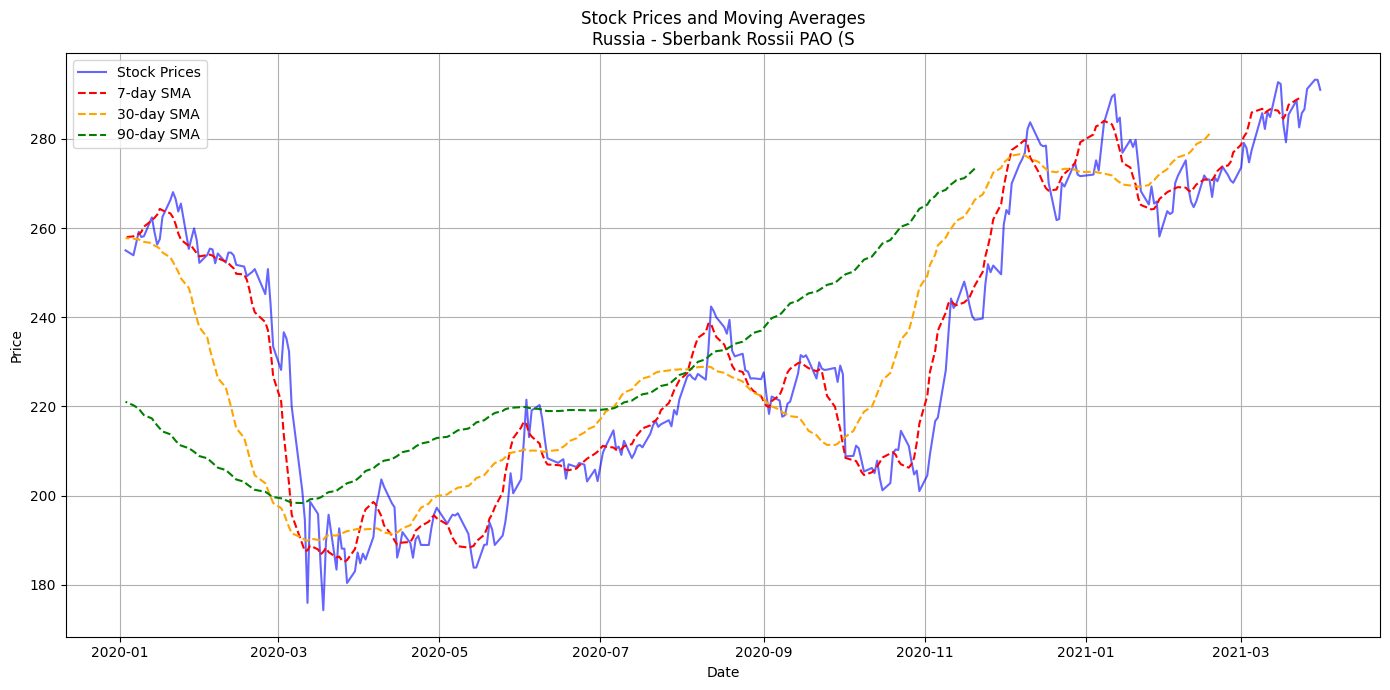

In [57]:
# Calculate the 7-day Simple Moving Average (SMA)
combined_df['7_SMA'] = combined_df['Price'].rolling(window=7).mean()

# Calculate the 30-day Simple Moving Average (SMA)
combined_df['30_SMA'] = combined_df['Price'].rolling(window=30).mean()

# Calculate the 90-day Simple Moving Average (SMA)
combined_df['90_SMA'] = combined_df['Price'].rolling(window=90).mean()

# Select a specific company for visualization (for visual clarity)
selected_company = company_names[0]
company_df = combined_df[combined_df['Company'] == selected_company]  # Replace 'YourCompanyName' with the desired company's name

plt.figure(figsize=(14, 7))

# Plotting the stock prices
plt.plot(company_df['Date'], company_df['Price'], label='Stock Prices', color='blue', alpha=0.6)

# Plotting the 7-day moving average
plt.plot(company_df['Date'], company_df['7_SMA'], label='7-day SMA', color='red', linestyle='--')

# Plotting the 30-day moving average
plt.plot(company_df['Date'], company_df['30_SMA'], label='30-day SMA', color='orange', linestyle='--')

# Plotting the 90-day moving average
plt.plot(company_df['Date'], company_df['90_SMA'], label='90-day SMA', color='green', linestyle='--')

plt.title('Stock Prices and Moving Averages'+'\n'+selected_company)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Relative Strength Index

Measures the speed and change of price movements. RSI oscillates between zero and 100 and is typically used to identify overbought or oversold conditions.

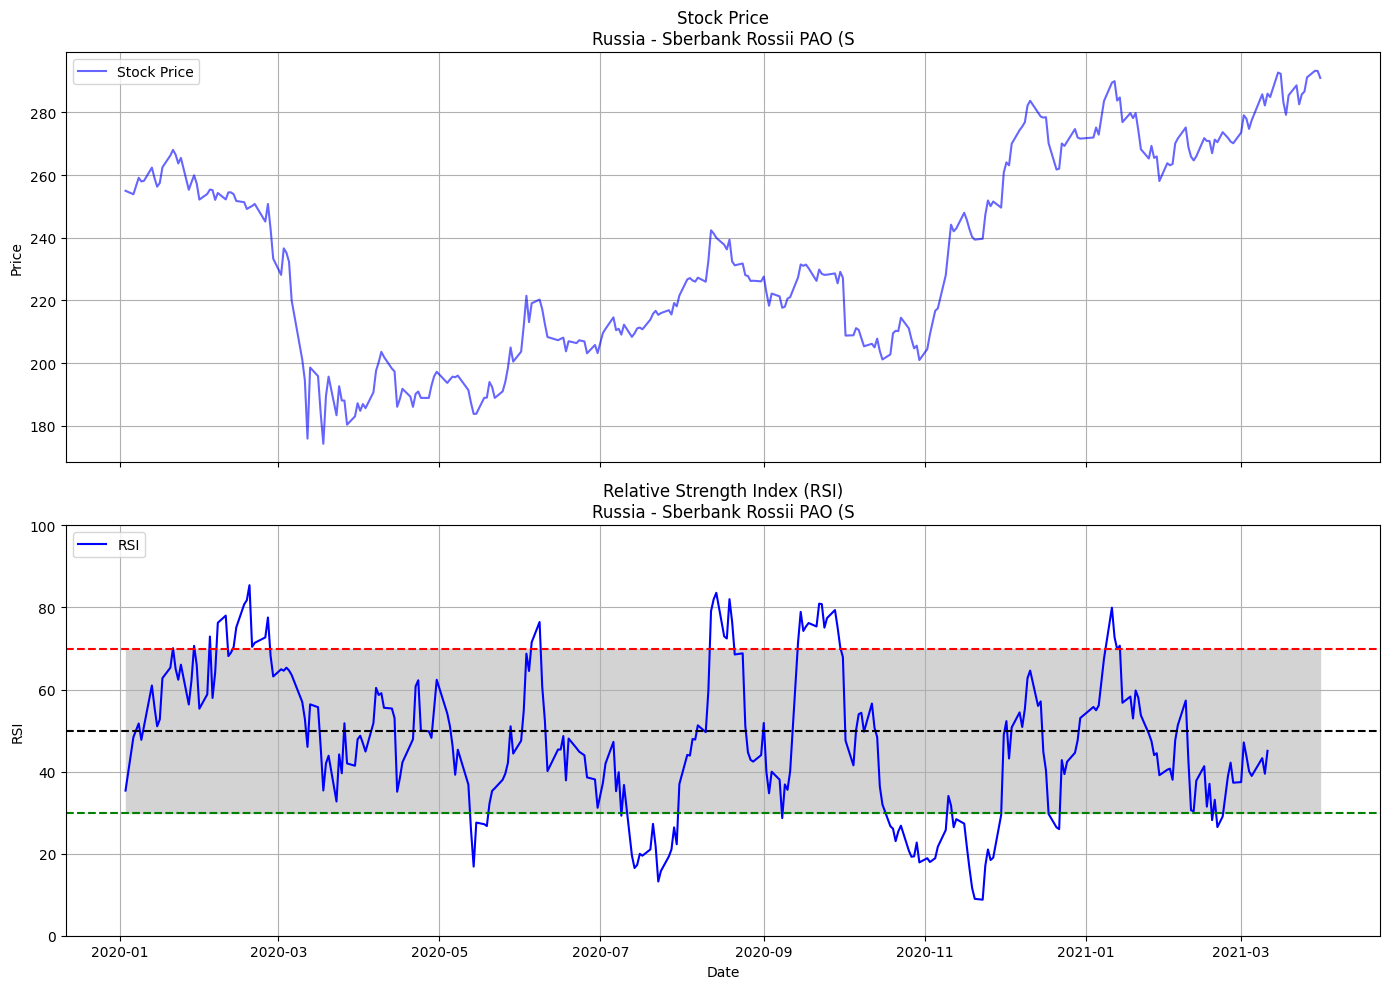

In [58]:
# Define RSI function for later
def compute_rsi(data, window):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()

    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    
    return RSI

combined_df['RSI'] = compute_rsi(combined_df['Price'], 14)

# Select a specific company for visualization (for clarity)
company_df = combined_df[combined_df['Company'] == selected_company]  # Replace 'YourCompanyName' with the desired company's name

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plotting the stock price on the first subplot
ax1.plot(company_df['Date'], company_df['Price'], label='Stock Price', color='blue', alpha=0.6)
ax1.set_title('Stock Price'+'\n'+selected_company)
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend(loc='upper left')

# Plotting the RSI on the second subplot
ax2.plot(company_df['Date'], company_df['RSI'], label='RSI', color='blue')

# Adding the overbought threshold
ax2.axhline(70, color='red', linestyle='--')

# Adding the oversold threshold
ax2.axhline(30, color='green', linestyle='--')

# Adding the neutral line
ax2.axhline(50, color='black', linestyle='--')

ax2.fill_between(company_df['Date'], y1=30, y2=70, color='lightgray')

ax2.set_title('Relative Strength Index (RSI)'+'\n'+selected_company)
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.set_ylim([0, 100])
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


### Moving Average Convergence Divergence

Momentum indicator that shows the relationship between two moving averages.

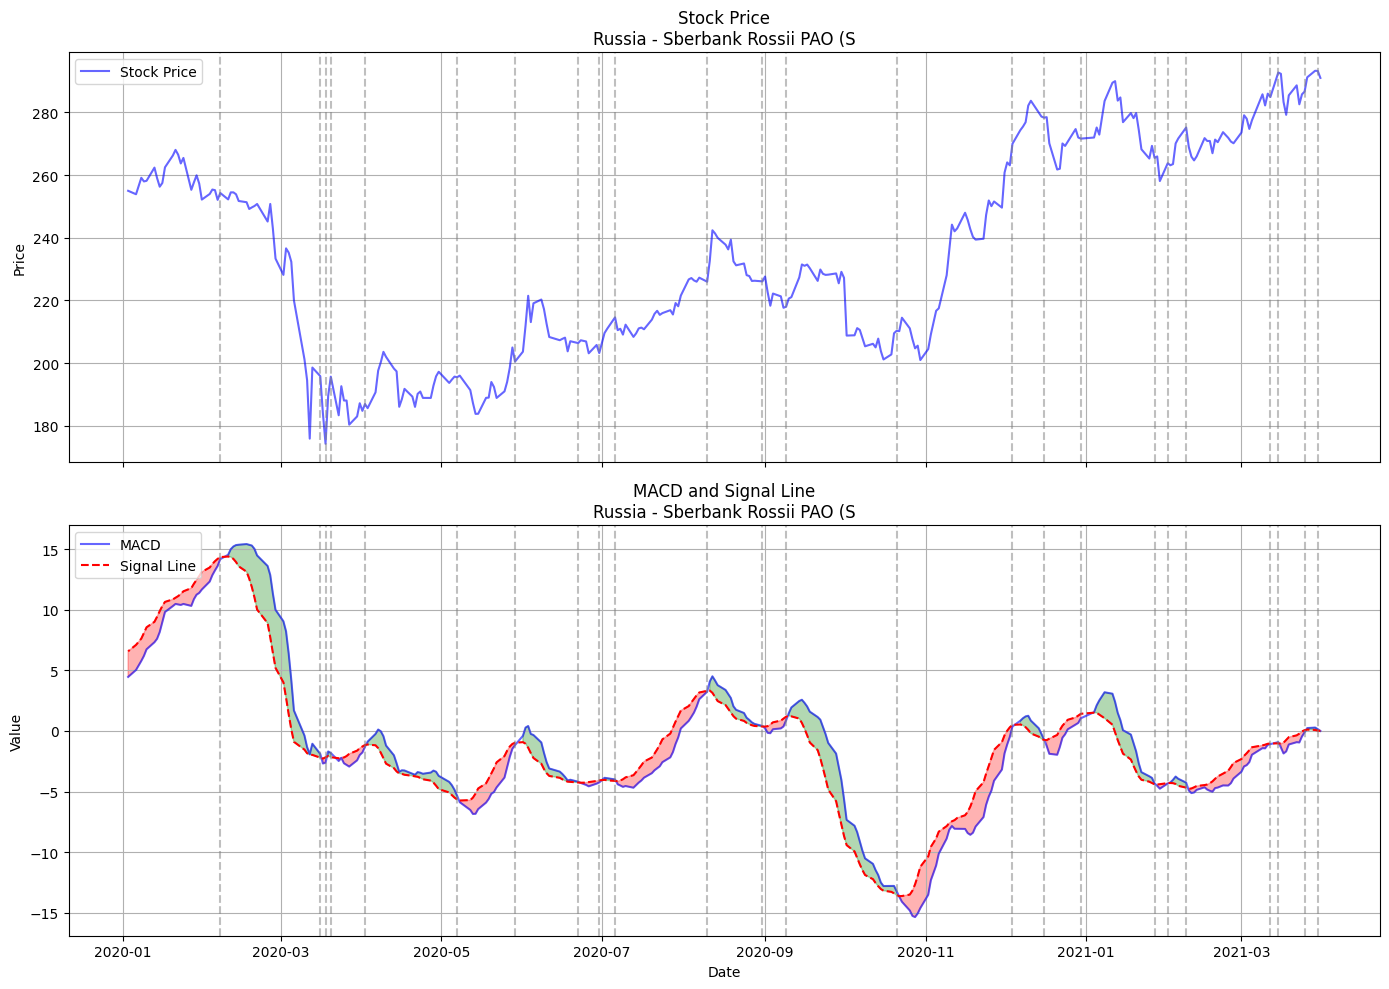

In [59]:
# Calculate the Short Term Exponential Moving Average
combined_df['14_EMA'] = combined_df['Price'].ewm(span=14, adjust=False).mean()

# Calculate the Long Term Exponential Moving Average
combined_df['30_EMA'] = combined_df['Price'].ewm(span=30, adjust=False).mean()

# Calculate MACD
combined_df['MACD'] = combined_df['14_EMA'] - combined_df['30_EMA']

# Calculate Signal Line
combined_df['Signal_Line'] = combined_df['MACD'].ewm(span=9, adjust=False).mean()

# Select a specific company for visualization (for clarity)
company_df = combined_df[combined_df['Company'] == selected_company]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plotting the stock price on the first subplot
ax1.plot(company_df['Date'], company_df['Price'], label='Stock Price', color='blue', alpha=0.6)
ax1.set_title('Stock Price'+'\n'+selected_company)
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend(loc='upper left')

# Plotting the MACD and Signal Line on the second subplot
ax2.plot(company_df['Date'], company_df['MACD'], label='MACD', color='blue', alpha=0.6)
ax2.plot(company_df['Date'], company_df['Signal_Line'], label='Signal Line', color='red', linestyle='--')

# Highlighting the area where MACD is above the signal line (potential buy zone)
ax2.fill_between(company_df['Date'], company_df['MACD'], company_df['Signal_Line'], where=(company_df['MACD'] > company_df['Signal_Line']), color='green', alpha=0.3)

# Highlighting the area where MACD is below the signal line (potential sell zone)
ax2.fill_between(company_df['Date'], company_df['MACD'], company_df['Signal_Line'], where=(company_df['MACD'] <= company_df['Signal_Line']), color='red', alpha=0.3)

# Identify intersection points
crossings = ((company_df['MACD'] > company_df['Signal_Line']) & (company_df['MACD'].shift(1) <= company_df['Signal_Line'].shift(1))) | ((company_df['MACD'] < company_df['Signal_Line']) & (company_df['MACD'].shift(1) >= company_df['Signal_Line'].shift(1)))

# Plot vertical lines on both subplots at the intersection points
# Visually indicates potential 'action' points of buy/sell
for date in company_df['Date'][crossings]:
    ax1.axvline(x=date, color='gray', linestyle='--', alpha=0.5)
    ax2.axvline(x=date, color='gray', linestyle='--', alpha=0.5)


ax2.set_title('MACD and Signal Line'+'\n'+selected_company)
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()


### Bollinger Bands

In [147]:
def calculate_bollinger_bands(data, window=20):
    rolling_mean = data['y'].rolling(window=window).mean()
    rolling_std = data['y'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    
    return upper_band, lower_band


# Exploratory Data Analysis

- Visualize stock price trends for different companies.
- Visualize distribution of returns.
- Correlation analysis between different technical indicators.

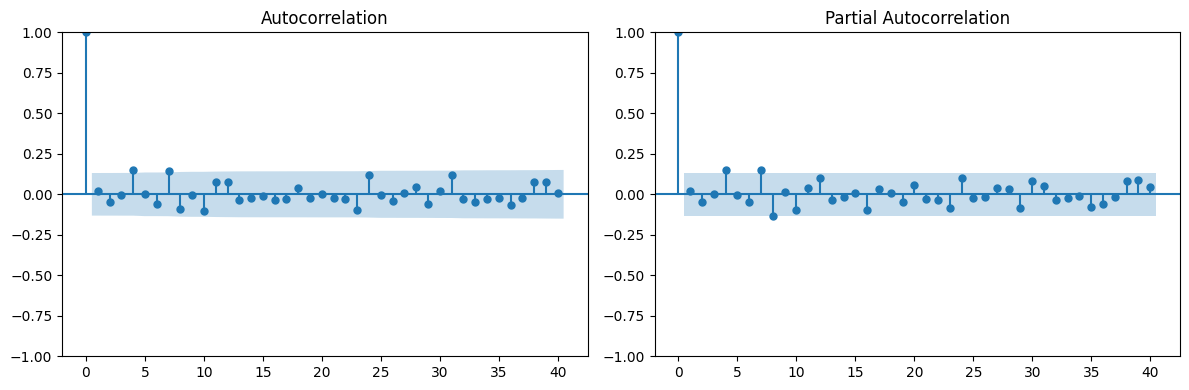

In [61]:
# Select a specific company for analysis
company_df = combined_df[combined_df['Company'] == selected_company].copy()

# First differencing to make the series stationary
company_df['Price_Diff'] = company_df['Price'].diff()

# Drop NaN values introduced by differencing
company_df.dropna(inplace=True)

# Plot ACF and PACF to help decide on p and q
# Visual aid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(company_df['Price_Diff'], lags=40, ax=ax1)
plot_pacf(company_df['Price_Diff'], lags=40, ax=ax2)
plt.tight_layout()
plt.show()

# ARIMA - Model Development

## Model Selection

- Consider models like ARIMA, Prophet, LSTM, and other time series forecasting models.
- Use cross-validation on the training set to tune hyperparameters.

In [62]:
# Train and Test function, so that we can pass multiple companies or variable pdq values.
def train_test_arima_for_company(company_name, train, test, p, d, q):
    # Filter data for the given company and ensure it's sorted by date
    train_data = train[train['Company'] == company_name].sort_values(by='Date')
    test_data = test[test['Company'] == company_name].sort_values(by='Date')

    # Ensure the 'Date' column is in datetime format
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    test_data['Date'] = pd.to_datetime(test_data['Date'])

    # Fit the ARIMA Model on the training data
    model = ARIMA(train_data['Price'], order=(p, d, q))
    results = model.fit()

    # Forecast the values for the test set duration
    forecast = results.forecast(steps=len(test_data))

    # Evaluate the model's performance
    mse = mean_squared_error(test_data['Price'], forecast)
    rmse = np.sqrt(mse)
    print(f"Company: {company_name}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Plot the actual vs. predicted values
    plt.figure(figsize=(14, 7))
    plt.plot(train_data['Date'], train_data['Price'], label='Training Data', color='blue', alpha=0.6)
    plt.plot(test_data['Date'], test_data['Price'], label='Actual Test Data', color='green', alpha=0.6)
    plt.plot(test_data['Date'], forecast, label='ARIMA Forecast', color='red', linestyle='--')
    plt.title(f'ARIMA Model Forecast vs Actuals for {company_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [63]:
# Optimization function to determine pdq
def arima_grid_search_for_company(company_name, train, p_values, d_values, q_values):
    # Filter training data for the given company
    train_data = train[train['Company'] == company_name]['Price']
    
    best_aic = float("inf")
    best_order = None
    best_model = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(train_data, order=order)
                    results = model.fit()
                    # Check if the current model's AIC is lower than the previous best
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = order
                        best_model = results
                except:
                    continue

    return company_name, best_order, best_aic

In [64]:
# Define the range of values for p, d, q
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Company', 'Best_Order', 'Best_AIC'])

# Loop through all companies and save the results in the DataFrame
for company in train['Company'].unique():
    company_name, best_order, best_aic = arima_grid_search_for_company(company, train, p_values, d_values, q_values)
    results_df.loc[len(results_df)] = [company_name, best_order, best_aic]

# Display the results
print(results_df)

                           Company Best_Order     Best_AIC
0  Russia - Sberbank Rossii PAO (S  (2, 1, 2)  1495.339450
1  Turkey - Koc Holding AS (KCHOL)  (0, 1, 0)   252.962985
2  Egypt - Medinet Nasr Housing (M  (1, 1, 2)  -475.198244
3  Brazil - Minerva SABrazil (BEEF  (2, 1, 2)   258.573667
4  Argentina - Pampa Energia SA (P  (2, 1, 2)  1026.506608
5  Colombia - Cementos Argos SA (C  (2, 2, 2)  3125.110634
6  South Africa - Impala Platinum   (2, 1, 2)  3966.301034
7  South Korea - Dongkuk Steel Mil  (0, 2, 1)  3669.768705


## Model Training

- Train the selected model on the training data.

c:\Users\danie\miniconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Company: South Korea - Dongkuk Steel Mil
Root Mean Squared Error (RMSE): 1587.469158465997


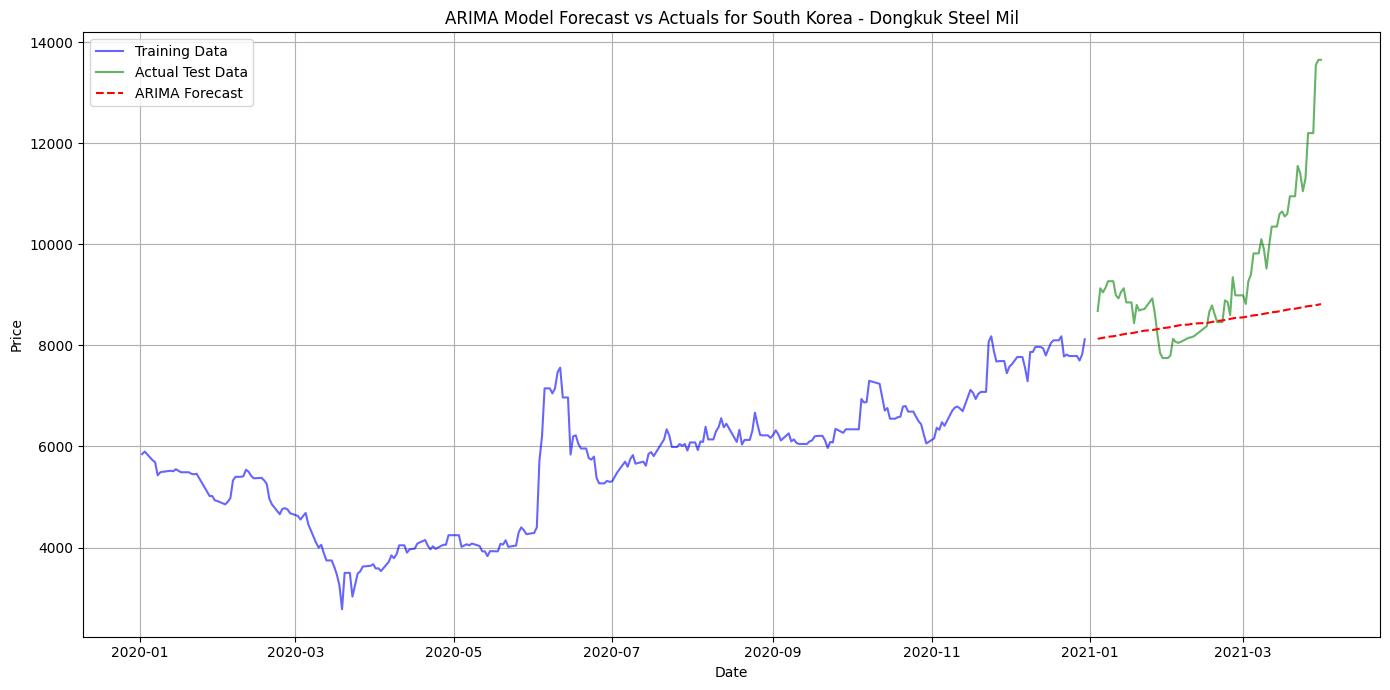

In [66]:
# Test with one company
company_name = row[1]['Company']
best_order = row[1]['Best_Order']
    
# Use the train_test_arima_for_company function for each company
train_test_arima_for_company(company_name, train, test, *best_order)

# Investment Recommendations

These simple recommendations are based on Bollinger Bands. Bollinger Bands consist of three lines:

- Middle Band: This is a simple moving average (SMA) of a stock's price over the last X periods.
- Upper Band: This is calculated as the sum of the middle band and the product of a number of standard deviations and the standard deviation of the stock's price over the last X periods.
- Lower Band: This is calculated as the middle band minus the product of standard deviations and the standard deviation of the stock's price over the last X periods.

Put simply:

- Middle Band: 20-day SMA
- Upper Band: 20-day SMA + (2 * 20-day standard deviation of price)
- Lower Band: 20-day SMA - (2 * 20-day standard deviation of price)

The logic then for the investment recommendations are:

- BUY: When the price crosses below the lower band (indicating potential oversold condition).
- SELL: When the price crosses above the upper band (indicating potential overbought condition).
- HOLD: When the price is between the bands.

# LSTM

## Model Selection

After having some divergence with the ReLU activation function, I've switched to 'tanh' to keep the results bounded and prevent divergence.

In [67]:
def generate_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='tanh', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [68]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Model Training

In [69]:
def train_lstm_model(company_name, train, model):
    # Filter and preprocess the data
    train_data = train[train['Company'] == company_name]['Price'].values.reshape(-1, 1)
    
    # Normalize the data
    scaler = MinMaxScaler()
    train_data_normalized = scaler.fit_transform(train_data)
    
    # Create sequences
    X_train = []
    y_train = []
    for i in range(60, len(train_data_normalized)):  # Using a sequence length of 60
        X_train.append(train_data_normalized[i-60:i, 0])
        y_train.append(train_data_normalized[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Reshape for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    return model, scaler

## Model Evaluation

### Rolling Forecast

Recursive forecasting involves using a model to predict the next time step, then incorporating that forecasted value as part of the input data to predict subsequent time steps. 

* We start at the end of 2020, and forecast for the next 60 days using the forecasted results for 2021 as input for further forecasting.

In [143]:
def predict_and_plot_lstm_rolling_forecast(company_name, train, test, model, scaler, step=1):
    # Filter and preprocess the data
    train_data = train[train['Company'] == company_name]['Price'].values.reshape(-1, 1)
    test_data = test[test['Company'] == company_name]['Price'].values.reshape(-1, 1)
    
    train_dates = train[train['Company'] == company_name]['Date'].values
    test_dates = test[test['Company'] == company_name]['Date'].values

    # Normalize the train data
    train_data_normalized = scaler.transform(train_data)
    
    # List to store rolling forecast predictions
    rolling_predictions = []

    # Start with the last 60 days of the training data as the initial sequence
    input_sequence = train_data_normalized[-60:].tolist()

    # Loop through the test set and predict step by step
    for i in range(0, len(test_data), step):
        X_test = np.reshape(input_sequence, (1, 60, 1))
        
        # Predict the next day's price
        predicted_price = model.predict(X_test, verbose=0)
        
        # Inverse transform the predicted price
        predicted_price_unscaled = scaler.inverse_transform(predicted_price)
        
        # Append to our list of rolling predictions
        rolling_predictions.extend([predicted_price_unscaled[0,0]] * step)
        
        # Update the input sequence with the predicted value and drop the oldest value
        for _ in range(step):
            input_sequence.append(predicted_price[0].tolist())
            input_sequence.pop(0)

    # Ensure the length of predictions matches the test data
    rolling_predictions = rolling_predictions[:len(test_data)]
    
    # Convert rolling predictions to a numpy array
    rolling_predictions = np.array(rolling_predictions).reshape(-1, 1)
    
    # Compute MAPE
    mape = mean_absolute_percentage_error(test_data, rolling_predictions)

    # Convert dates to a format that can be used with our Bollinger Bands function
    all_dates = pd.to_datetime(np.concatenate([train_dates, test_dates]))
    all_prices = np.concatenate([train_data, test_data])
    data_for_bollinger = pd.DataFrame({'ds': all_dates, 'y': all_prices.flatten()})
    data_for_bollinger = data_for_bollinger.sort_values(by='ds')


    # Bollinger Bands
    upper_band, lower_band = calculate_bollinger_bands(data_for_bollinger)

    # Sort data by date
    sorted_data = data_for_bollinger.sort_values(by='ds')
    sorted_dates = sorted_data['ds'].values
    sorted_prices = sorted_data['y'].values

    # Investment Decisions
    decisions = []
    for i in range(1, len(test_data)):
        if test_data[i] < lower_band[len(train_data) + i] and test_data[i - 1] >= lower_band[len(train_data) + i - 1]:
            decisions.append("BUY")
        elif test_data[i] > upper_band[len(train_data) + i] and test_data[i - 1] <= upper_band[len(train_data) + i - 1]:
            decisions.append("SELL")
        else:
            decisions.append("HOLD")

    # Convert numpy.datetime64 to datetime.datetime
    def convert_to_datetime(date):
        return pd.Timestamp(date).to_pydatetime()

    # Visualization
    plt.figure(figsize=(14, 7))
    
    # Plot the actual values for both 2020 and 2021
    plt.plot(sorted_dates, sorted_prices, 'b-', label='Actual Prices')
    
    # Plot the rolling forecast values for 2021
    plt.plot(pd.to_datetime(test_dates), rolling_predictions, 'r-', label='Rolling Forecast for 2021')
    
    # Plot Bollinger Bands with fill_between
    plt.plot(sorted_dates, upper_band, color='grey', linestyle='--', label='Upper Bollinger Band')
    plt.plot(sorted_dates, lower_band, color='grey', linestyle='--', label='Lower Bollinger Band')
    plt.fill_between(sorted_dates, lower_band, upper_band, color='grey', alpha=0.2)
    
    #plt.fill_between(np.arange(len(train_data), len(train_data) + len(test_data)), lower_band[len(train_data):], upper_band[len(train_data):], color='cyan', alpha=0.2)
    plt.title(f'LSTM {step}-Day Rolling Forecast vs Actual Prices for {company_name}\nMAPE: {mape:.2f}%')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print decisions with HOLD as a range
    print(f"Investment Recommendations for {company_name}")
    start_hold_date = None
    for i, (date, decision) in enumerate(zip(test_dates[1:], decisions)):
        date = convert_to_datetime(date)
        if decision == "HOLD":
            if start_hold_date is None:
                start_hold_date = date
            continue
        else:
            if start_hold_date:
                print(f"HOLD from {start_hold_date.strftime('%Y-%m-%d')} to {date.strftime('%Y-%m-%d')}")
                start_hold_date = None
            print(f"{date.strftime('%Y-%m-%d')}: {decision}")

    # If the last decision(s) were HOLD
    if start_hold_date:
        last_date = convert_to_datetime(test_dates[-1])
        print(f"HOLD from {start_hold_date.strftime('%Y-%m-%d')} to {last_date.strftime('%Y-%m-%d')}")

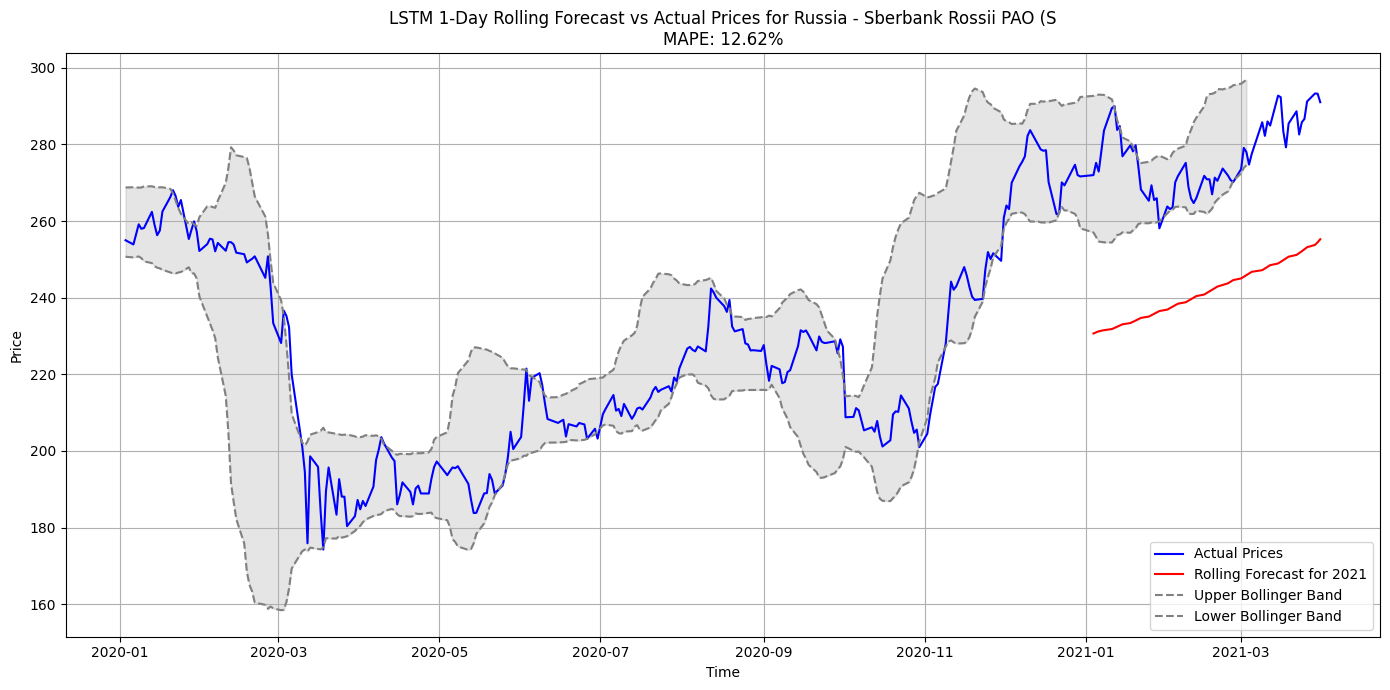

Investment Recommendations for Russia - Sberbank Rossii PAO (S
HOLD from 2021-03-30 to 2021-02-26
2021-02-26: BUY
HOLD from 2021-02-25 to 2021-01-29
2021-01-29: BUY
HOLD from 2021-01-28 to 2021-01-20
2021-01-20: SELL
HOLD from 2021-01-19 to 2021-01-14
2021-01-14: SELL
HOLD from 2021-01-13 to 2021-01-12
2021-01-12: SELL
HOLD from 2021-01-11 to 2021-01-04


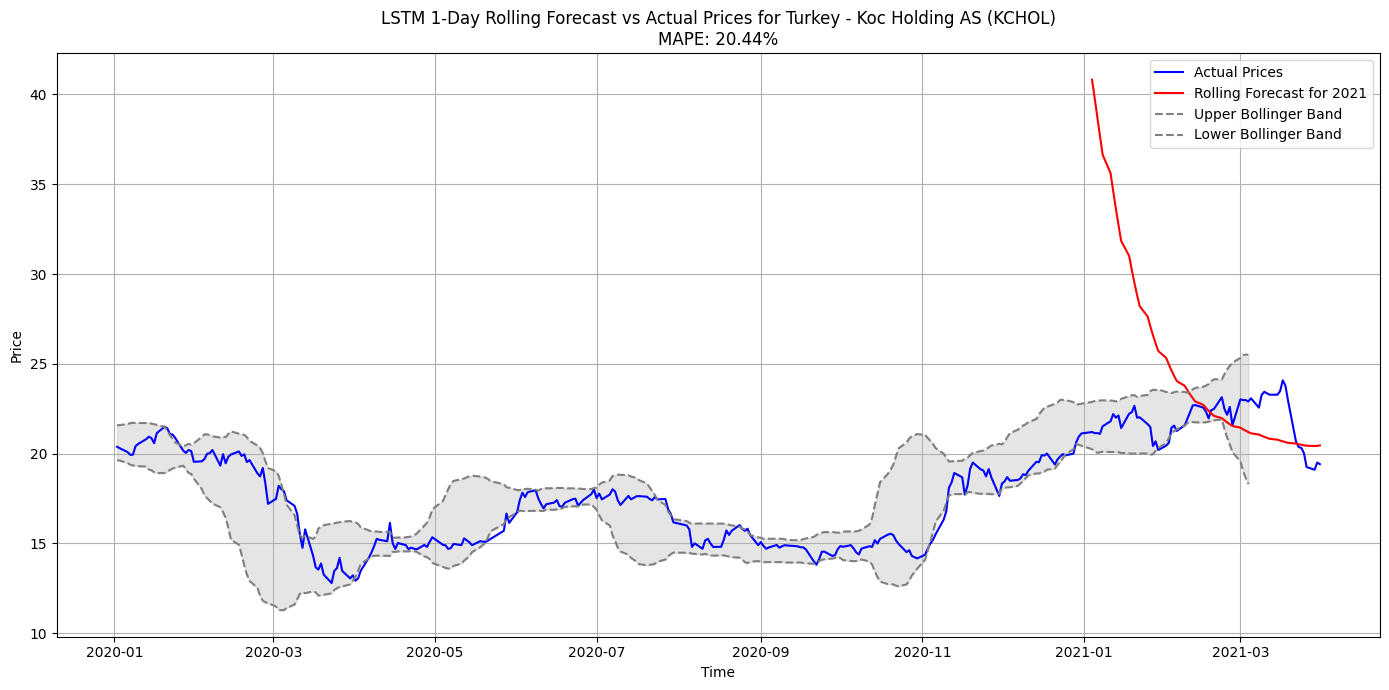

Investment Recommendations for Turkey - Koc Holding AS (KCHOL)
HOLD from 2021-03-30 to 2021-02-05
2021-02-05: BUY
HOLD from 2021-02-04 to 2021-02-02
2021-02-02: BUY
HOLD from 2021-02-01 to 2021-01-04


In [144]:
# Loop companies
for company in train['Company'].unique()[:2]:
    # Generate the model
    input_shape = (60, 1)  # 60 time steps with 1 feature
    model = generate_lstm_model(input_shape)

    # Train the model
    model, scaler = train_lstm_model(company, train, model)

    # Predict and plot
    predict_and_plot_lstm_rolling_forecast(company, train, test, model, scaler, step = 1)


# Prophet

## Rolling Forecast

In [145]:
def rolling_forecast_prophet(company_name, combined_df):
    # Data Preparation
    data = combined_df[combined_df['Company'] == company_name][['Date', 'Price']]
    data.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)

    # Split the data into training and test sets
    train_data = data[data['ds'].dt.year == 2020]
    test_data = data[data['ds'].dt.year == 2021]

    # Initialize an empty list to store predictions
    predictions = []

    # Rolling forecast
    for i in range(len(test_data)):
        # Use the last 60 days of training data to forecast the next day
        temp_train = pd.concat([train_data, test_data.iloc[:i]]).tail(60)
        
        model = Prophet(daily_seasonality=True, changepoint_prior_scale=0.1)
        model.fit(temp_train)
        
        future = model.make_future_dataframe(periods=1, include_history=False)
        forecast = model.predict(future)
        
        predictions.append(forecast['yhat'].values[0])

    # Compute MAPE for the 2021 predictions
    mape = mean_absolute_percentage_error(test_data['y'].values, predictions)

    # Bollinger Bands
    upper_band, lower_band = calculate_bollinger_bands(data)

    # Visualization
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot the actual values for both 2020 and 2021
    ax.plot(data['ds'], data['y'], 'b-', label='Actual Prices')
    
    # Plot the rolling forecast values for 2021
    ax.plot(test_data['ds'], predictions, 'r-', label='Rolling Forecast for 2021')
    
    # Plot Bollinger Bands with fill_between
    ax.plot(data['ds'], upper_band, color='grey', linestyle='--' , label='Upper Bollinger Band')
    ax.plot(data['ds'], lower_band, color='grey', linestyle='--', label='Lower Bollinger Band')
    ax.fill_between(data['ds'], lower_band, upper_band, color='grey', alpha=0.2)
    ax.set_title(f'Prophet Rolling Forecast vs Actual Prices with Bollinger Bands for {company_name}\nMAPE for 2021: {mape:.2f}%')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Compute Bollinger Bands
    rolling_mean = test_data['y'].rolling(window=20).mean()
    rolling_std = test_data['y'].rolling(window=20).std()
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)

    # Investment decisions based on Bollinger Bands
    decisions = []
    for i in range(1, len(test_data)):
        if predictions[i] > upper_band.iloc[i]:
            decisions.append("SELL")
        elif predictions[i] < lower_band.iloc[i]:
            decisions.append("BUY")
        else:
            decisions.append("HOLD")

    # Convert numpy.datetime64 to datetime.datetime
    def convert_to_datetime(date):
        return pd.Timestamp(date).to_pydatetime()

    # Print decisions with HOLD as a range
    test_dates = test_data['ds'].values
    start_hold_date = None
    for i, (date, decision) in enumerate(zip(test_dates[1:], decisions)):
        date = convert_to_datetime(date)
        if decision == "HOLD":
            if start_hold_date is None:
                start_hold_date = date
            continue
        else:
            if start_hold_date:
                print(f"HOLD from {start_hold_date.strftime('%Y-%m-%d')} to {date.strftime('%Y-%m-%d')}")
                start_hold_date = None
            print(f"{date.strftime('%Y-%m-%d')}: {decision}")

    # If the last decision(s) were HOLD
    if start_hold_date:
        last_date = convert_to_datetime(test_dates[-1])
        print(f"HOLD from {start_hold_date.strftime('%Y-%m-%d')} to {last_date.strftime('%Y-%m-%d')}")


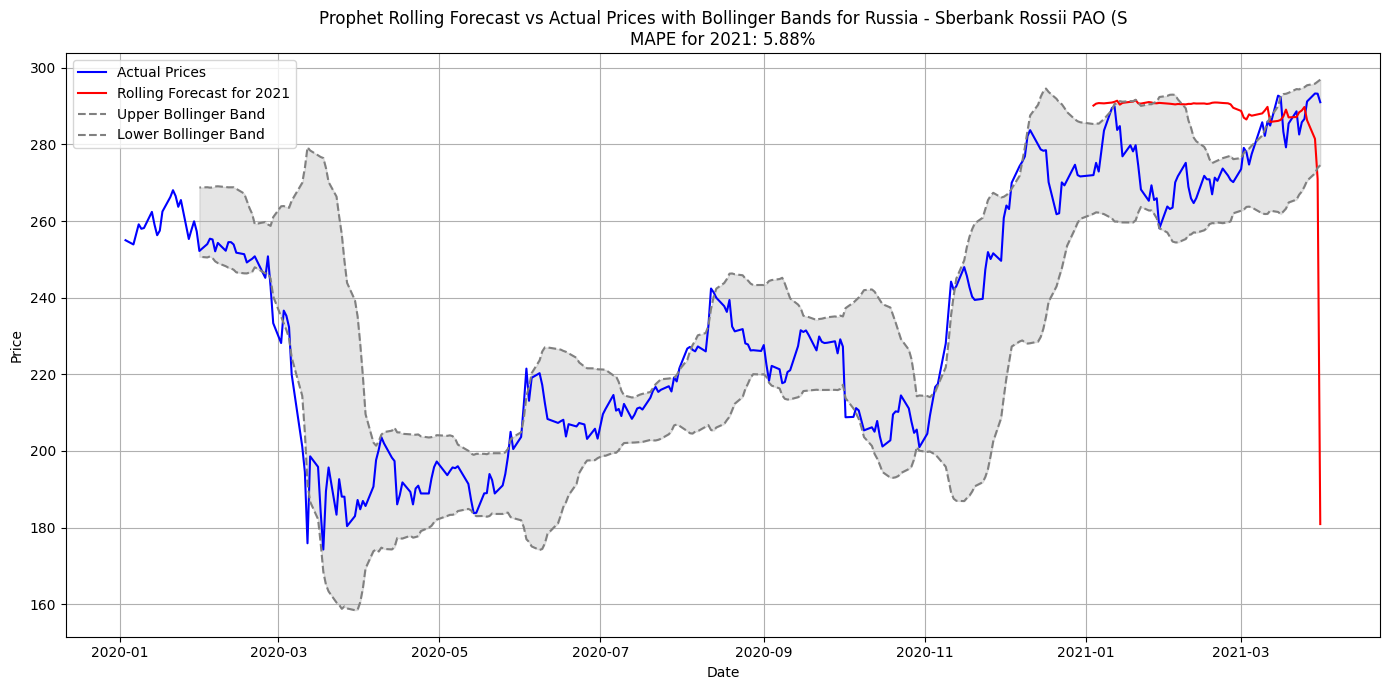

HOLD from 2021-03-30 to 2021-02-15
2021-02-15: SELL
2021-02-12: SELL
2021-02-11: SELL
2021-02-10: SELL
2021-02-09: SELL
2021-02-08: SELL
2021-02-05: SELL
2021-02-04: SELL
2021-02-03: SELL
2021-02-02: SELL
2021-02-01: SELL
2021-01-29: SELL
2021-01-28: SELL
2021-01-27: SELL
2021-01-26: SELL
2021-01-25: SELL
2021-01-22: SELL
2021-01-21: SELL
2021-01-20: SELL
2021-01-19: SELL
2021-01-18: SELL
2021-01-15: SELL
2021-01-14: SELL
2021-01-13: SELL
2021-01-12: SELL
HOLD from 2021-01-11 to 2021-01-04


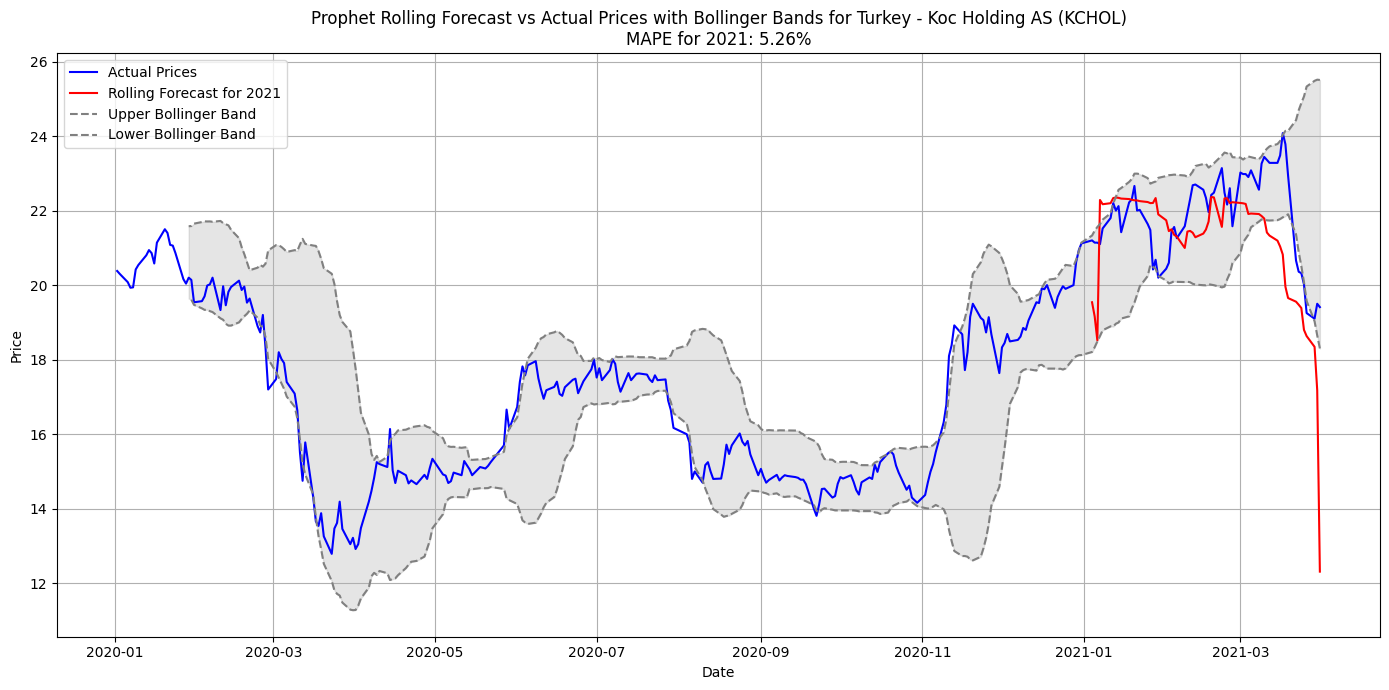

HOLD from 2021-03-30 to 2021-02-22
2021-02-22: BUY
HOLD from 2021-02-19 to 2021-02-17
2021-02-17: BUY
2021-02-16: BUY
2021-02-15: BUY
2021-02-12: BUY
2021-02-11: BUY
2021-02-10: BUY
2021-02-09: BUY
2021-02-08: BUY
2021-02-05: BUY
HOLD from 2021-02-04 to 2021-01-06
2021-01-06: BUY
2021-01-05: BUY
2021-01-04: BUY


In [146]:
for company in train['Company'].unique()[:2]:
    rolling_forecast_prophet(company, combined_df)

# Summary

Throughout this notebook, we took a comprehensive tour through different techniques to develop a robust forecasting system for stock price valuations. We explored various forecasting methodologies, including ARIMA, LSTM, and Prophet, each with its unique strengths and considerations.

## Key Findings:

**ARIMA Model**: While ARIMA provided a baseline model, it had limitations in capturing non-linear trends and seasonalities inherent in stock price movements. Its predictions were often linear and didn't adapt well to sudden market changes.

**LSTM Model**: The LSTM neural network model showed promise in capturing the non-linear patterns in stock price movements. We implemented both batch and rolling forecast strategies (though only included the rolling forecast in this final draft). The rolling forecast, in particular, provided a more dynamic approach, updating the model with the latest data as we moved through 2021.

**Prophet Model**: Prophet, with its flexibility in handling daily seasonality and incorporating change points, offered a more intuitive approach to forecasting. Its ability to adapt to the stock's historical data and predict future movements made it a valuable tool in our analysis.

**Bollinger Bands**: We integrated Bollinger Bands as a measure of volatility and to aid in our BUY, HOLD, SELL decision-making process. The bands provided a visual representation of the stock's price relative to its recent history, helping identify potential overbought or oversold conditions.

## Recommendations and Investment Decisions:

Using the combined insights from the models and Bollinger Bands, we were able to make investment decisions. While these predictions were not an accurate forecast for the data, our approach aimed to minimize losses and reduce the HOLD period. By forecasting on daily, weekly, and monthly bases, we tailored our investment strategy to align with the stated investing principles and make suggestions.

## Conclusion

While the LSTM and Prophet models captured some patterns in the data, they often struggled to accurately forecast the stock prices. The Bollinger Bands, when overlaid on our forecasts, further highlighted the deviations between our predictions and the actual stock prices, emphasizing the inherent volatility and unpredictability of stock markets.

Given these challenges, our models, though sophisticated, faced limitations in their predictive accuracy. While they provided some directional insights, the actual stock price movements often deviated from our forecasts, lightlighting the complexities of financial markets.